<a href="https://colab.research.google.com/github/andreasslien/machine_learning_group_40/blob/main/Machine_Learning_Project_Group_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports (General)

In [41]:
# Libraries used throughout notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
# Installing interpret for EBM functionality
!pip install interpret

#Load dataset (General)

In [43]:
# Pandas used to retrieve and represent data
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
    header=None)

# Setting names of all columns
df.columns = [
    "ID", "Diagnosis", "Radius_Mean", "Texture_Mean", "Perimeter_Mean", "Area_Mean", "Smoothness_Mean", "Compactness_Mean", "Concavity_Mean", "Concave_points_Mean", "Symmetry_Mean", "Fractal_Dimension_Mean", "Radius_SE", "Texture_SE",
    "Perimeter_SE", "Area_SE", "Smoothness_SE", "Compactness_SE", "Concavity_SE", "Concave_points_SE", "Symmetry_SE", "Fractal_Dimension_SE", "Radius_Worst", "Texture_Worst", "Perimeter_Worst",
    "Area_Worst", "Smoothness_Worst", "Compactness_Worst", "Concavity_Worst", "Concave_points_Worst", "Symmetry_Worst", "Fractal_Dimension_Worst"
]

# Removing columns that have a high correlation, see 'Correlation analysis' file
df = df.drop(["Concave_points_Mean","Texture_Worst", "Area_Mean", "Area_Worst", "Perimeter_Mean", "Perimeter_SE", "Radius_Worst"], axis=1)

# Separating attributes from labels
label = df.columns[1]
attributes = df.columns[2:]

y = df[label].apply(lambda x: 0 if x == "B" else 1) #Turning response into 0 (if benign) and 1 (if malignant) for possible use in EBM
X = df[attributes]

In [44]:
# Printting of attributes and labels
print("Attributes:")
print(X)
print("Labels:")
print(y)

Attributes:
     Radius_Mean  Texture_Mean  ...  Symmetry_Worst  Fractal_Dimension_Worst
0          17.99         10.38  ...          0.4601                  0.11890
1          20.57         17.77  ...          0.2750                  0.08902
2          19.69         21.25  ...          0.3613                  0.08758
3          11.42         20.38  ...          0.6638                  0.17300
4          20.29         14.34  ...          0.2364                  0.07678
..           ...           ...  ...             ...                      ...
564        21.56         22.39  ...          0.2060                  0.07115
565        20.13         28.25  ...          0.2572                  0.06637
566        16.60         28.08  ...          0.2218                  0.07820
567        20.60         29.33  ...          0.4087                  0.12400
568         7.76         24.54  ...          0.2871                  0.07039

[569 rows x 23 columns]
Labels:
0      1
1      1
2      1
3   

#Divide into training and test data (General)

In [45]:
# Imported library used
from sklearn.model_selection import train_test_split

# Splitting into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False) # Shuffle is set to false to ensure reproducability

#**EBM**

#Explore the dataset (EBM)

In [46]:
# Imported libraries used
from interpret import show
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(X, y, name = 'Train Data')
show(hist), # Distribution of data shown

(None,)

#Training with default hyperparameters (EBM)

In [47]:
# Imported libraries used
from interpret.glassbox import ExplainableBoostingClassifier

# Setting the random seed
np.random.seed(42) 

# Create model
base_classifier = ExplainableBoostingClassifier(n_jobs = -1, validation_size=0.3)

# Fit the model
base_classifier.fit(X_train, y_train)

# Renaming
ebm_base_search_estimator = base_classifier

# Training Randomized Search CV (EBM)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from interpret.glassbox import ExplainableBoostingClassifier

# Setting the random seed
np.random.seed(42)

#Max bins
max_bins = [205, 255, 305]
#Learning rate
learning_rate = [0.001, 0.01, 0.1]
#Max rounds
max_rounds = [2500, 5000, 7500]
#Max leaves
max_leaves = [2,3,4]
#Min samples leaf
min_samples_leaf = [2, 3]

# Create the random grid
random_grid = {'max_bins': max_bins,
               'learning_rate': learning_rate,
               'max_rounds': max_rounds,
               'max_leaves': max_leaves,
               'min_samples_leaf': min_samples_leaf,

}
# Create base model for tuning
ebm_randomized_cv = ExplainableBoostingClassifier()

# Random search of parameters, 4 iterations. The program does not return any values if the number of iterations is higher, because of high computation time.
randomized_search_cv = RandomizedSearchCV(estimator = ebm_randomized_cv, param_distributions = random_grid, n_iter = 4, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
randomized_search_cv.fit(X_train, y_train)

# Setting ebm_randomized_search_cv_estimator to the estimator that on the highest accuracy on average over the 5 folds
ebm_randomized_search_cv_estimator = randomized_search_cv.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


In [49]:
print('Best tried combination of hyperparameters with RSCV:')
print(randomized_search_cv.best_params_)


Best tried combination of hyperparameters with RSCV:
{'min_samples_leaf': 3, 'max_rounds': 7500, 'max_leaves': 2, 'max_bins': 255, 'learning_rate': 0.1}


# Accuracy: default and randomized (EBM)

In [50]:
from sklearn.metrics import accuracy_score

# Using default hyperparameters to predict test set
ebm_default_predictions = ebm_base_search_estimator.predict(X_test)
# Using RSCV hyperparameters to predict test set
ebm_randomized_predictions = ebm_randomized_search_cv_estimator.predict(X_test)


print('Default hyperparameters accuracy:')
print(accuracy_score(y_test, ebm_default_predictions))
print('RSCV hyperparameters accuracy')
print(accuracy_score(y_test, ebm_randomized_predictions))



Default hyperparameters accuracy:
0.9707602339181286
RSCV hyperparameters accuracy
0.9590643274853801


#Global explanations (EBM)

In [51]:
# By selecting 'Summary' as 'Select Component to Graph' the 15 most important attributes based on mean absolute score of importance are shown
# By selecting an attribute specific information is shown about each attribute

ebm_global = ebm_base_search_estimator.explain_global(name='EBM')
show(ebm_global)

In [52]:
# visualize present 'Summary' from above

ebm_viz = ebm_global.visualize()
ebm_viz

# Styling of visualize (EBM)

In [53]:
# Imported libraries used
from interpret.visual import plot
from interpret.visual.plot import plot_horizontal_bar

# The content from plot_horizontal_bar_difference is copied from plot_horizontal_bar at https://github.com/interpretml/interpret/blob/master/python/interpret-core/interpret/visual/plot.py
# A change in the code was necesarry to show a 'Relative importance' as the xtitle

# Copyright (c) 2019 Microsoft Corporation
# Distributed under the MIT software license

COLORS = ["#1f77b4", "#ff7f0e", "#808080"] # Must include different colors

def plot_horizontal_bar_difference(
    data_dict, multiclass=False, title="", xtitle="Relative importance", ytitle="", start_zero=False # Change xtitle from '' to 'Relative importance'
):
    if data_dict.get("scores", None) is None:  # pragma: no cover
        return None
    scores = data_dict["scores"].copy()
    names = data_dict["names"].copy()
    values = data_dict.get("values", None)
    if values is not None:
        values = data_dict["values"].copy()
        names = _names_with_values(names, values)
    if data_dict.get("perf", None) is not None and title == "":
        title_items = []

        predicted = data_dict["perf"]["predicted"]
        actual = data_dict["perf"]["actual"]
        predicted_score = data_dict["perf"]["predicted_score"]
        actual_score = data_dict["perf"]["actual_score"]

        if (
            "meta" in data_dict and "label_names" in data_dict["meta"]
        ):  # Upgraded classification
            label_names = data_dict["meta"]["label_names"]
            predicted = label_names[predicted]
            title_items.append(
                "Predicted ({}): {:.3f}".format(predicted, predicted_score)
            )

            if not np.isnan(actual):
                actual = label_names[actual]
                title_items.append("Actual ({}): {:.3f}".format(actual, actual_score))
        else:  # Regression or old form of classification
            predicted_score = _pretty_number(predicted_score)
            title_items.append("Predicted ({})".format(predicted_score))

            if not np.isnan(actual):
                actual_score = _pretty_number(actual_score)
                title_items.append("Actual ({})".format(actual_score))

        title = " | ".join(title_items)
    if not multiclass:
        # color by positive/negative:
        color = [COLORS[0] if value <= 0 else COLORS[1] for value in scores]
    else:
        color = []
    extra = data_dict.get("extra", None)
    if extra is not None:
        scores.extend(extra["scores"])
        names.extend(extra["names"])
        if values is not None:
            values.extend(extra["values"])
        color.extend([COLORS[2]] * len(extra["scores"]))
    x = scores
    y = names
    traces = []
    if multiclass:
        for index, cls in enumerate(data_dict["meta"]["label_names"]):
            trace_scores = [x[index] for x in data_dict["scores"]] + [
                data_dict["extra"]["scores"][0][index]
            ]
            trace_names = data_dict["names"] + [data_dict["extra"]["names"]]
            traces.append(
                go.Bar(y=trace_names, x=trace_scores, orientation="h", name=cls)
            )
    else:
        traces.append(go.Bar(x=x, y=y, orientation="h", marker=dict(color=color)))

    if start_zero:
        x_range = [0, np.max(x)]
    else:
        max_abs_x = np.max(np.abs(x))
        if multiclass:
            max_abs_x = np.sum(np.array(x), axis=1)
        x_range = [-max_abs_x, max_abs_x]
    layout = dict(
        title=title,
        yaxis=dict(automargin=True, title=ytitle),
        xaxis=dict(range=x_range, title=xtitle),
    )
    if multiclass:
        layout["barmode"] = "relative"
    figure = go.Figure(data=traces, layout=layout)
    return figure

plot.plot_horizontal_bar_difference = plot_horizontal_bar_difference # Replace old plot_horizontal_bar_difference with new one

# Top ranked attributes sorted by relative importance (EBM)

In [54]:
# Imported libraries used
from interpret.glassbox import ebm as ebm_import
import plotly.graph_objs as go

# The content from visualize_all_items is copied from visualize at https://github.com/interpretml/interpret/blob/master/python/interpret-core/interpret/glassbox/ebm/ebm.py
# A change in the code was necesarry to show a complete ranking

def visualize_all_items(self, key=None):
        """ Provides interactive visualizations.
        Args:
            key: Either a scalar or list
                that indexes the internal object for sub-plotting.
                If an overall visualization is requested, pass None.
        Returns:
            A Plotly figure.
        """
        """
        from ...visual.plot import (
            plot_continuous_bar,
            plot_horizontal_bar,
            sort_take,
            is_multiclass_global_data_dict,
        )
        """
        
        data_dict = self.data(key)
        if data_dict is None:
            return None

        # Overall graph
        if self.explanation_type == "global" and key is None:
            data_dict = plot.sort_take(
                data_dict, sort_fn=lambda x: -abs(x), top_n=23, reverse_results=True # Change top_n from 15 to 23, to show a complete ranking
            )
            total = 0
            for i in data_dict['scores']:
              total += i
            
            data_dict['scores'] = [x / total for x in data_dict['scores']]
            figure = plot_horizontal_bar_difference(
                data_dict,
                title="",
                start_zero=True,
            )

            return figure

        # Continuous feature graph
        if (
            self.explanation_type == "global"
            and self.feature_types[key] == "continuous"
        ):
            title = self.feature_names[key]
            if is_multiclass_global_data_dict(data_dict):
                figure = plot_continuous_bar(
                    data_dict, multiclass=True, show_error=False, title=title
                )
            else:
                figure = plot_continuous_bar(data_dict, title=title)

            return figure

        return super().visualize(key)

# Adding the new function to allow further use of visualize_all_items on an EBM global model
ebm_import.ebm.EBMExplanation.visualize_all_items = visualize_all_items

ebm_global = ebm_base_search_estimator.explain_global(name='EBM')
ebm_global.visualize_all_items()


#Local explanations (EBM)

In [55]:
# By selecting a row in the scroll down bar it is possible to see how different attributes affected individual classifications

ebm_local = ebm_base_search_estimator.explain_local(X_test, y_test, name='EBM')
show(ebm_local)


# **Random Forest**

#Training Random Forest with Default values (Random Forest)

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Setting random seed
np.random.seed(42)

# Create a default valued model model
rf_base_search_estimator = RandomForestClassifier()

# Fit model
rf_base_search_estimator.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Training Randomized Search CV (Random Forest)

In [57]:
# Imported libraries used
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Setting the random seed to ensure reproducability

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Method of measuring the quality of a split
criterion = ['entropy', 'gini']
# Number of features to consider at every split
max_features = ['sqrt', 'auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create base model for tuning
random_classifier = RandomForestClassifier(random_state = 42)

# Random search of parameters, 5-fold CV being used, 
# Searches among 100 iterations, does take approximately 14 min to run

# np.random.seed(42)
randomized_search_cv = RandomizedSearchCV(estimator = random_classifier, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=np.random.RandomState(42), n_jobs = -1)

# Fit the model
randomized_search_cv.fit(X_train, y_train)

# Setting rd_randomized_search_cv_estimator to the estimator that on the highest accuracy on average over the 5 folds
rf_randomized_search_cv_estimator = randomized_search_cv.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.9min finished


In [58]:
print('Best tried combination of hyperparameters with RSCV:')
print(randomized_search_cv.best_params_)

# {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': True}


Best tried combination of hyperparameters with RSCV:
{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini', 'bootstrap': True}


# Accuracy on default values and randomized

In [59]:
# Imported libraries used
from sklearn.metrics import accuracy_score

# Using default hyperparameters to predict test set
rf_default_predictions = rf_base_search_estimator.predict(X_test)
# Using RSCV hyperparameters to predict test set
rf_randomized_predictions = rf_randomized_search_cv_estimator.predict(X_test)


print('Default hyperparamets accuracy:')
print(accuracy_score(y_test, rf_default_predictions))
print('RSCV hyperparameters accuracy')
print(accuracy_score(y_test, rf_randomized_predictions))


Default hyperparamets accuracy:
0.9649122807017544
RSCV hyperparameters accuracy
0.9649122807017544


#Transparency in Random Forest model

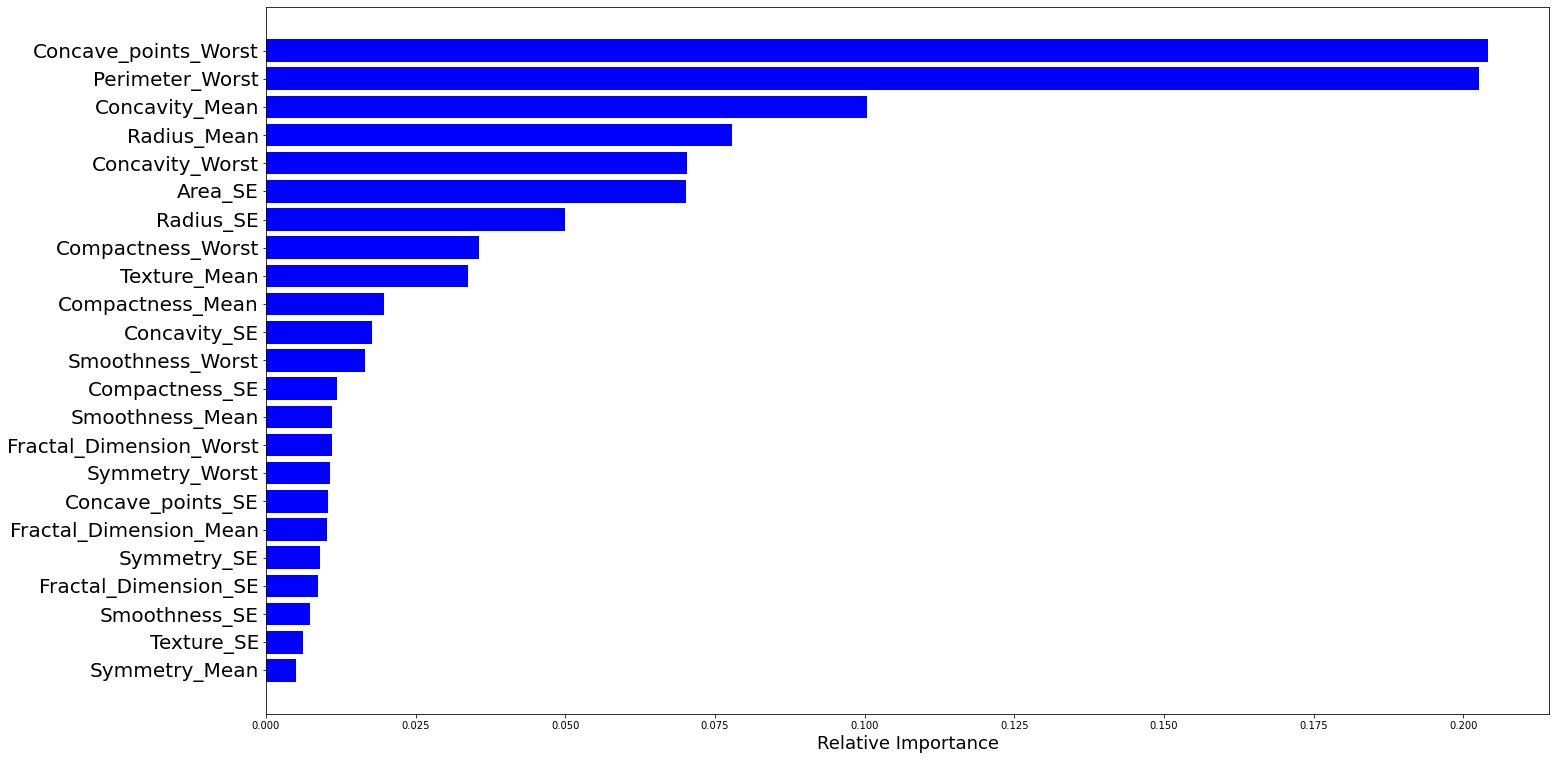

In [60]:
# Create a list with the names of all the attributes
feature_names = []
for i in attributes:
  feature_names.append(i)

# Find the immportances to corresponding attributes
importances = rf_base_search_estimator.feature_importances_
indices = np.argsort(importances)
indices = indices[:]

# Graphic adjustments
plt.figure(figsize=(23,13))
plt.rc('ytick', labelsize=20)
plt.xlabel('xlabel', fontsize=18)
plt.title('')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


